In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from functools import partial
from itertools import product
from contextlib import contextmanager

from xbbg import blp
from xbbg import __version__, const, pipeline
from xbbg.io import logs, files, storage
from xbbg.core import utils, conn, process
from xbbg.core.conn import connect
import datetime
from datetime import timedelta

sns.set(style = "white")

import warnings
warnings.filterwarnings("ignore")

In [2]:
def bdh_intra(tickers = None, start_date = datetime.datetime.now()-timedelta(days = 365), end_date = datetime.datetime.now(), 
              typ='TRADE', freq = 1, **kwargs) -> pd.DataFrame:

    logger = logs.get_logger(bdh_intra, **kwargs)
    while conn.bbg_session(**kwargs).tryNextEvent(): pass
    request = process.create_request(
        service='//blp/refdata',
        request='IntradayBarRequest',
        settings = [
            ('security', tickers),
            ('eventType', typ),
            ('interval', freq),
            ('startDateTime', start_date),
            ('endDateTime', end_date)
        ],
        **kwargs,
    )
    logger.debug(f'Sending request to Bloomberg ...\n{request}')
    conn.send_request(request=request, **kwargs)

    res = pd.DataFrame(process.rec_events(process.process_bar, **kwargs))
    return res
    


In [3]:
def hist_data(tickers, start_date, end_date, condition = "LAST_PRICE"):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    clean_cols = []
    for col in data.columns:
        clean_cols.append(col[0])
    data.columns = clean_cols
    return data

In [4]:
def implied_realized_vol(pair = None, window_days = 180, sample_days = 90, log = True, volticker = None):
    
    # window_days is the period over which we want to look, sample_days is the size of the volatility sample
    # blackouts is event periods
    
    end_date = datetime.datetime.now()
    start_date = datetime.datetime.now()-timedelta(days = (window_days+sample_days))
    
    vec = bdh_intra(tickers= pair, start_date = start_date, end_date = end_date)
    
    if volticker is not None: vol_df = hist_data(tickers = volticker, start_date = start_date, end_date = end_date)
    vec = vec[["time", "close"]]
    if log == True:
        vec["close"] = vec["close"].apply(lambda x: np.log(x))
    vec["day"] = vec["time"].apply(lambda x: x.day)
    vec["hour"] = vec["time"].apply(lambda x: x.hour)
    vec["minute"] = vec["time"].apply(lambda x: x.minute)
    vec["4hr"] = vec["hour"].apply(lambda x: (x % 4))
    vec["12hr"] = vec["hour"].apply(lambda x: (x % 12))
    vec_30 = vec[(vec["minute"] == 0) | (vec["minute"]==30)]
    vec_60 = vec[(vec["minute"] == 0)]
    vec_4hr = vec[(vec["4hr"] == 0)]
    vec_12hr = vec[(vec["12hr"] == 0)]
    print(vec)
    minute_realized = []
    realized_30 = []
    realized_60 = []
    realized_4hr = []
    realized_12hr = []
    implied = []
    dates = []
    vols = []
    vols_perf = []
    vols_dates=[]
    vols_lagged_dates=[]
    
    for x in range(0, window_days):
        
        # Sample Window
        sample_end = end_date -timedelta(days = x)
        sample_start = sample_end - timedelta(days = sample_days)
        df = vec[(vec["time"] <= sample_end) & (vec["time"]>=sample_start)]
        df["diff"] = df["close"] - df["close"].shift(1)
        
        
        # Slices
        df_30 = df[(df["minute"] == 0) | (df["minute"]==30)]
        df_30["diff_30"] = df_30["close"]-df_30["close"].shift(1)
        df_60 = df[(df["minute"] == 0)]
        df_60["diff_60"] = df_60["close"]-df_60["close"].shift(1)
        df_4hr = df[(df["4hr"] == 0) & (df["minute"] == 0)]
        df_4hr["diff_4hr"] = df_4hr["close"]-df_4hr["close"].shift(1)
        df_12hr = df[(df["12hr"] == 0) & (df["minute"] == 0)]
        df_12hr["diff_12hr"] = df_12hr["close"]-df_12hr["close"].shift(1)
        # Realized vols
        min_rlz = (df["diff"].std()*np.sqrt(252*60*24))
        rlz_30 = df_30["diff_30"].std()*np.sqrt(252*24*2)
        rlz_60 = df_60["diff_60"].std()*np.sqrt(252*24)
        rlz_4hr = df_4hr["diff_4hr"].std()*(np.sqrt(252*6))
        rlz_12hr = df_12hr["diff_12hr"].std()*(np.sqrt(252*2))
        
        # Create series
        minute_realized.append(min_rlz)
        realized_30.append(rlz_30)
        realized_60.append(rlz_60)
        realized_4hr.append(rlz_4hr)
        realized_12hr.append(rlz_12hr)
        dates.append(sample_end)
        
        # Vol
        if volticker is not None:
            vol = vol_df[vol_df.index == sample_end.date()]
            if vol.empty == False:
                vols.append(vol.iloc[0].values[0]/100)
                vols_dates.append(sample_end.date())

            vol_lagged = vol_df[vol_df.index == sample_start.date()]
            if vol_lagged.empty == False:
                vols_perf.append(vol_lagged.iloc[0].values[0]/-100+min_rlz)
                vols_lagged_dates.append(sample_end.date())
        
    plt.figure(figsize = (12,12))
    ax1 = sns.lineplot(x = dates, y = minute_realized, label = "1-Minute")
    #ax2 = sns.lineplot(x = dates, y = realized_30, label = "30-Minute")
    #ax3 = sns.lineplot(x = dates, y = realized_60, label = "60-Minute")
    ax4 = sns.lineplot(x = dates, y = realized_4hr, label = "4-Hour")
    ax5 = sns.lineplot(x = dates, y = realized_12hr, label = "12-Hour")
    ax6 = sns.lineplot(x = vols_dates, y = vols, label = "%s (Implied)" % volticker)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.title("%s Realized Volatilities, %s C-Day Sample\n%s - %s"%(pair, sample_days, start_date, end_date))
    
    if volticker is not None:
        plt.figure(figsize = (12,12))
        ax7 = sns.lineplot(x = vols_lagged_dates, y = vols_perf, label = "Realized (1-Min) - %s (Lagged Implied) " % volticker, color = "red")
        plt.title("%s Implied Volatility Performance, %s C-Day Sample and Lag, \n%s - %s"%(pair, sample_days, start_date, end_date))
        ax7.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

                      time     close  day  hour  minute  4hr  12hr
0      2022-01-27 22:00:00  4.748058   27    22       0    2    10
1      2022-01-27 22:01:00  4.747971   27    22       1    2    10
2      2022-01-27 22:02:00  4.747971   27    22       2    2    10
3      2022-01-27 22:03:00  4.747971   27    22       3    2    10
4      2022-01-27 22:04:00  4.747971   27    22       4    2    10
...                    ...       ...  ...   ...     ...  ...   ...
206195 2022-08-12 09:23:00  4.892452   12     9      23    1     9
206196 2022-08-12 09:24:00  4.892527   12     9      24    1     9
206197 2022-08-12 09:25:00  4.892527   12     9      25    1     9
206198 2022-08-12 09:26:00  4.892752   12     9      26    1     9
206199 2022-08-12 09:27:00  4.892677   12     9      27    1     9

[206200 rows x 7 columns]


C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_14492/956976011.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff"] = df["close"] - df["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_14492/956976011.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["diff_30"] = df_30["close"]-df_30["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_14492/956976011.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

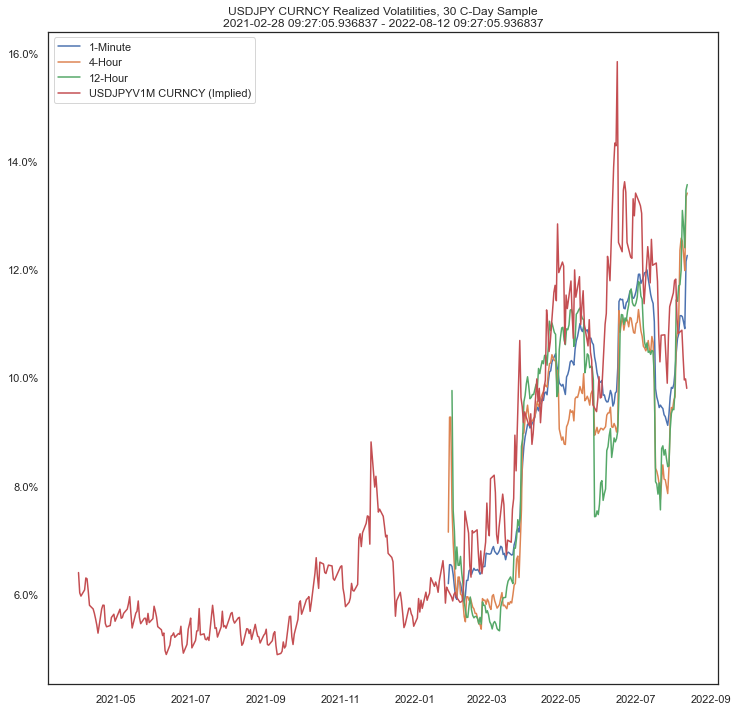

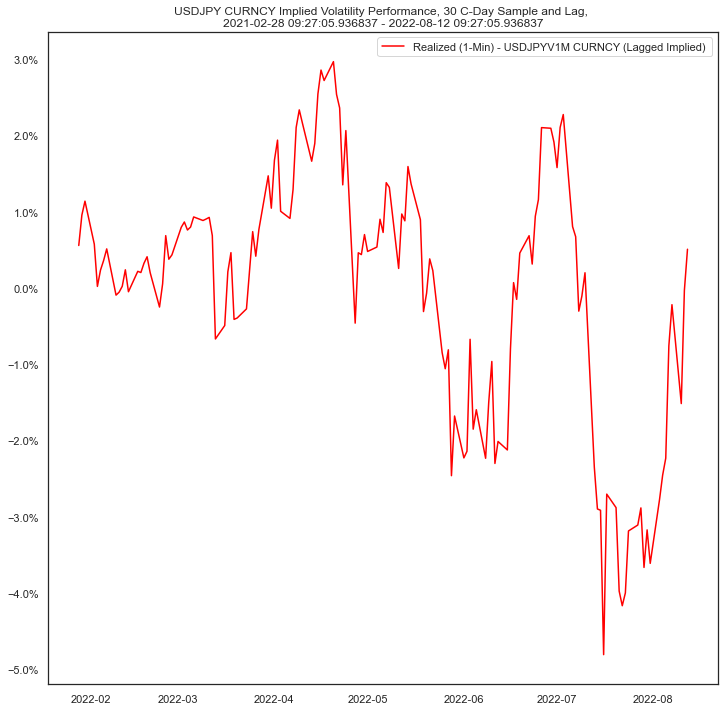

In [5]:
implied_realized_vol("USDJPY CURNCY", sample_days = 30, window_days = 500, volticker = "USDJPYV1M CURNCY")

                      time     close  day  hour  minute  4hr  12hr
0      2022-01-31 23:00:00  8.410777   31    23       0    3    11
1      2022-01-31 23:01:00  8.410777   31    23       1    3    11
2      2022-01-31 23:02:00  8.410665   31    23       2    3    11
3      2022-01-31 23:03:00  8.410610   31    23       3    3    11
4      2022-01-31 23:04:00  8.410220   31    23       4    3    11
...                    ...       ...  ...   ...     ...  ...   ...
190834 2022-08-16 14:29:00  8.363401   16    14      29    2     2
190835 2022-08-16 14:30:00  8.362759   16    14      30    2     2
190836 2022-08-16 14:31:00  8.362642   16    14      31    2     2
190837 2022-08-16 14:32:00  8.362876   16    14      32    2     2
190838 2022-08-16 14:33:00  8.362175   16    14      33    2     2

[190839 rows x 7 columns]


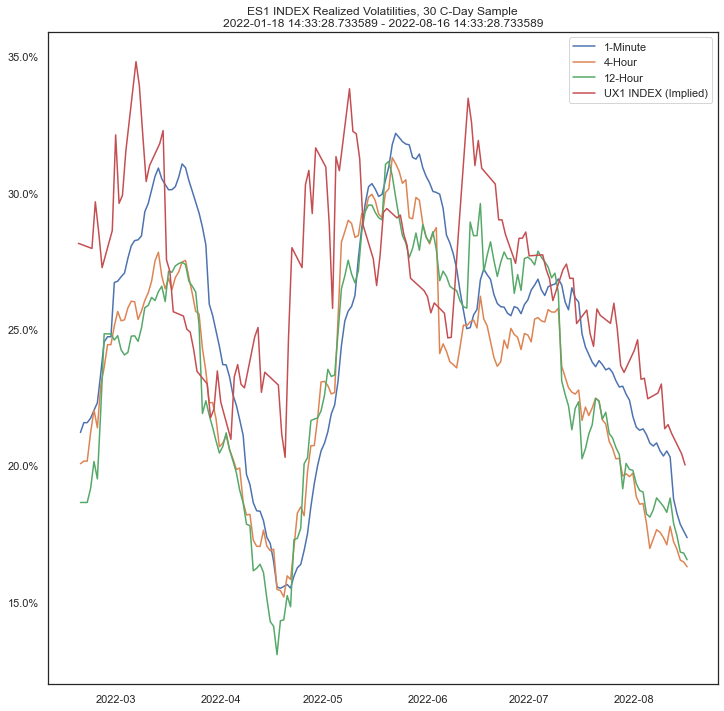

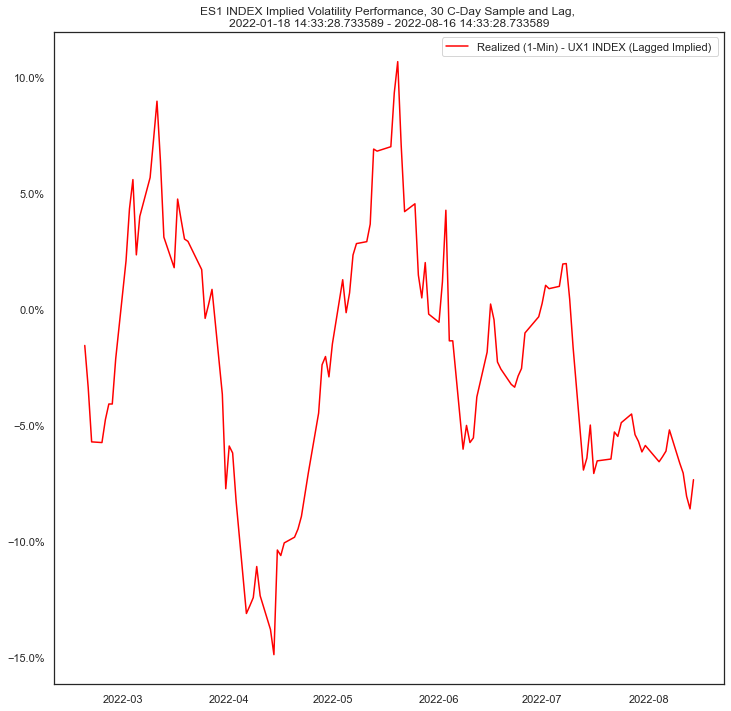

In [9]:
implied_realized_vol("ES1 INDEX", sample_days = 30, window_days = 180, volticker = "UX1 INDEX")

C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/3850481950.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff"] = df["close"] - df["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/3850481950.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["diff_30"] = df_30["close"]-df_30["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/3850481950.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

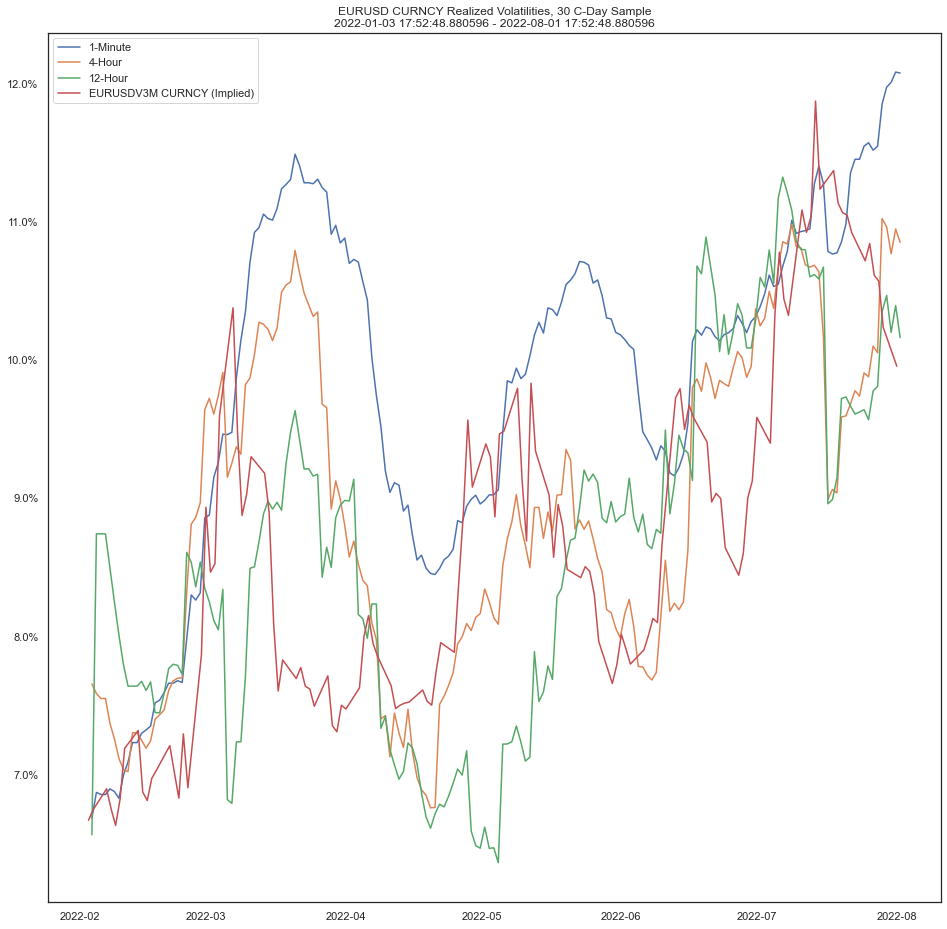

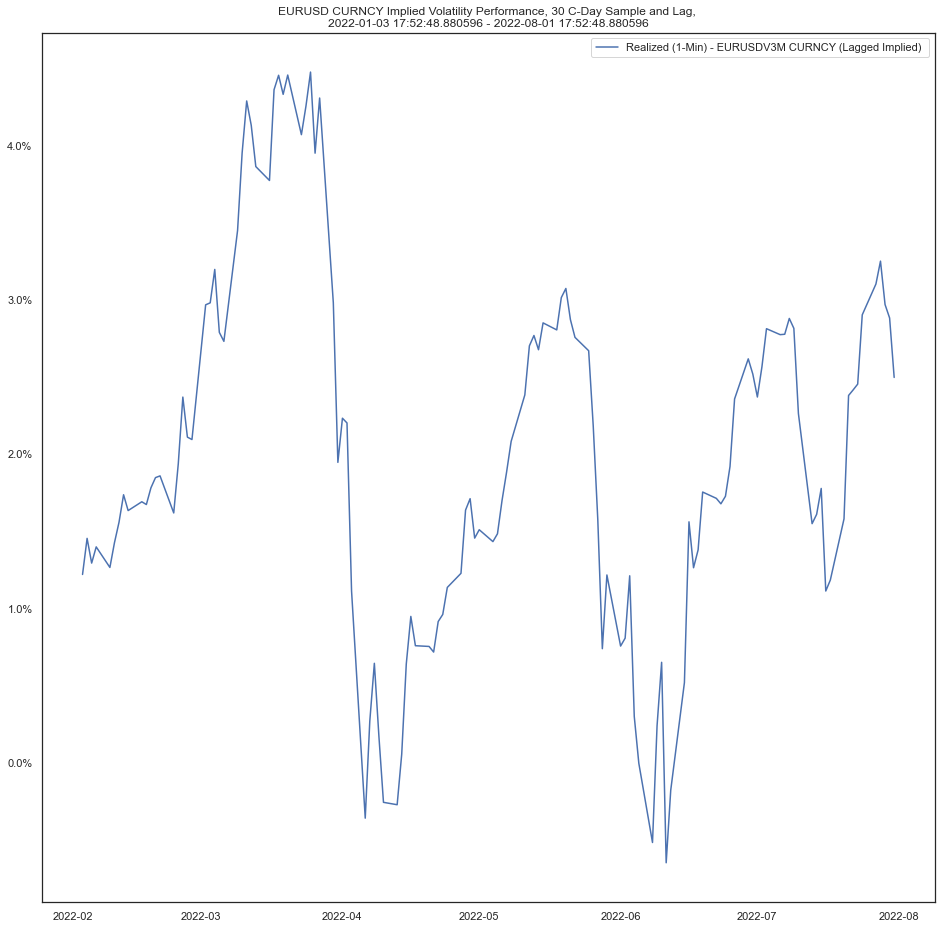

In [344]:
implied_realized_vol("EURUSD CURNCY", sample_days = 30, window_days = 180, volticker = "EURUSDV3M CURNCY")

C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/1582173127.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff"] = df["close"] - df["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/1582173127.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["diff_30"] = df_30["close"]-df_30["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/1582173127.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

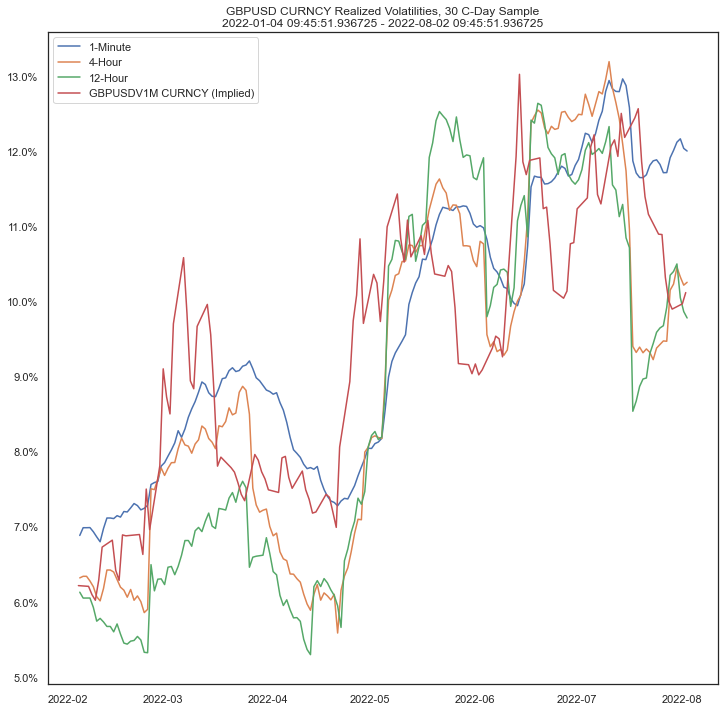

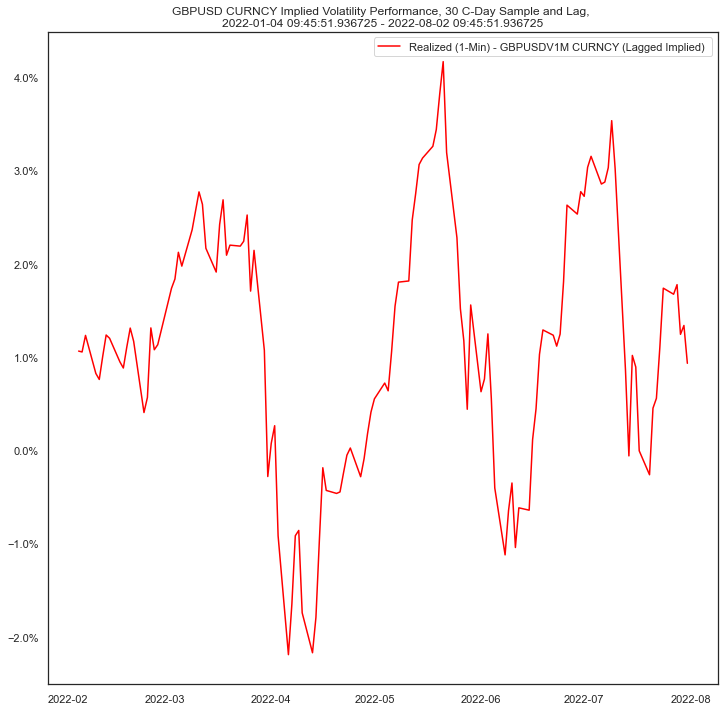

In [358]:
implied_realized_vol("GBPUSD CURNCY", sample_days = 30, window_days = 180, volticker = "GBPUSDV1M CURNCY")

                      time     close  day  hour  minute  4hr  12hr
0      2022-01-24 07:08:00  6.685112   24     7       8    3     7
1      2022-01-24 07:09:00  6.685112   24     7       9    3     7
2      2022-01-24 07:10:00  6.685112   24     7      10    3     7
3      2022-01-24 07:11:00  6.685112   24     7      11    3     7
4      2022-01-24 07:12:00  6.685112   24     7      12    3     7
...                    ...       ...  ...   ...     ...  ...   ...
120970 2022-08-08 11:25:00  6.827738    8    11      25    3    11
120971 2022-08-08 11:26:00  6.827738    8    11      26    3    11
120972 2022-08-08 11:28:00  6.827738    8    11      28    3    11
120973 2022-08-08 11:29:00  6.827738    8    11      29    3    11
120974 2022-08-08 11:30:00  6.827738    8    11      30    3    11

[120975 rows x 7 columns]


C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/956976011.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff"] = df["close"] - df["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/956976011.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["diff_30"] = df_30["close"]-df_30["close"].shift(1)
C:\Users\DRAMAS~1\AppData\Local\Temp/ipykernel_5588/956976011.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

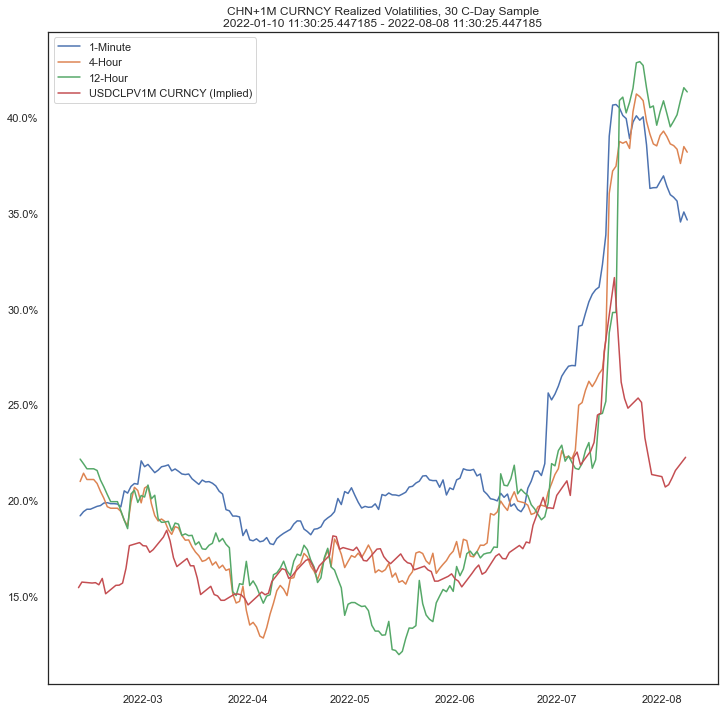

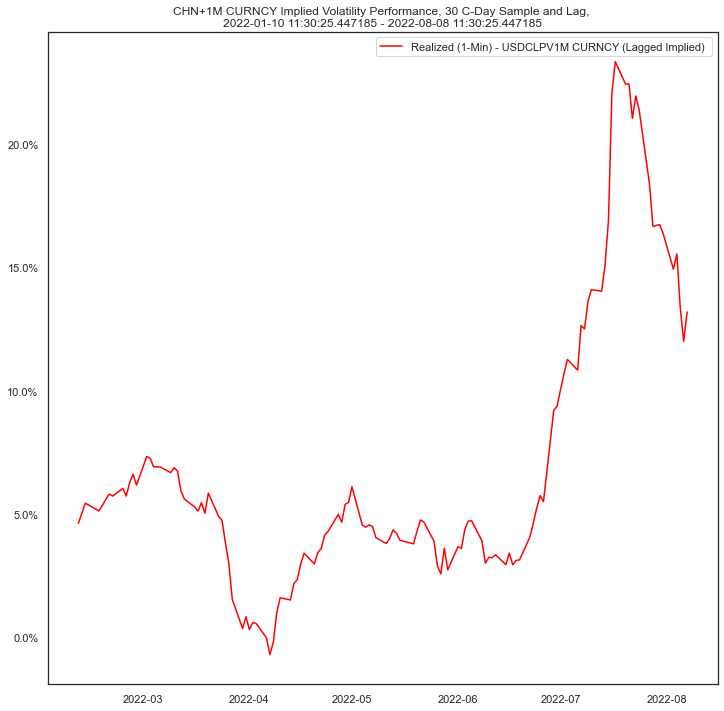

In [384]:
implied_realized_vol("CHN+1M CURNCY", sample_days = 30, window_days = 180, volticker = "USDCLPV1M CURNCY")

                      time     close  day  hour  minute  4hr  12hr
0      2022-01-31 22:00:00  1.851819   31    22       0    2    10
1      2022-01-31 22:01:00  1.851804   31    22       1    2    10
2      2022-01-31 22:02:00  1.851788   31    22       2    2    10
3      2022-01-31 22:03:00  1.851835   31    22       3    2    10
4      2022-01-31 22:04:00  1.852086   31    22       4    2    10
...                    ...       ...  ...   ...     ...  ...   ...
202843 2022-08-16 14:23:00  1.916746   16    14      23    2     2
202844 2022-08-16 14:24:00  1.916849   16    14      24    2     2
202845 2022-08-16 14:25:00  1.916893   16    14      25    2     2
202846 2022-08-16 14:26:00  1.916805   16    14      26    2     2
202847 2022-08-16 14:27:00  1.916776   16    14      27    2     2

[202848 rows x 7 columns]


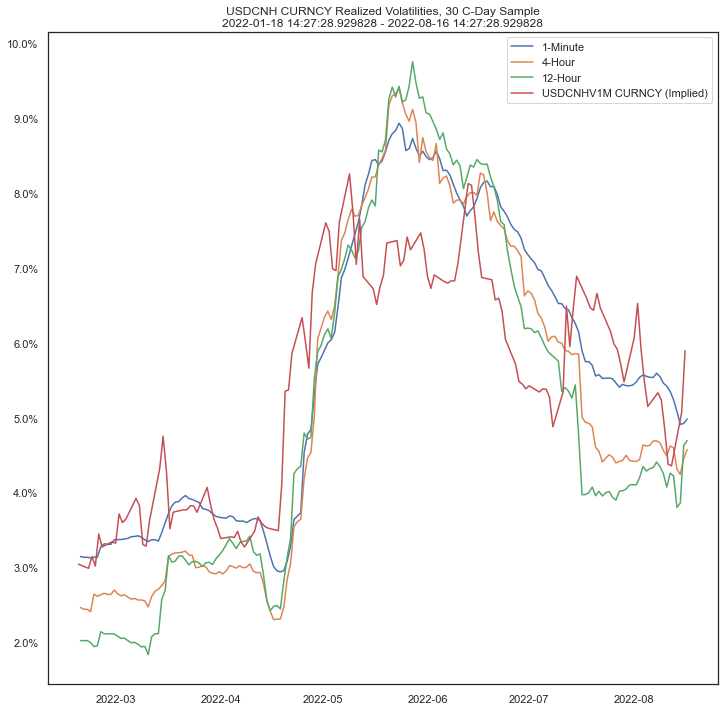

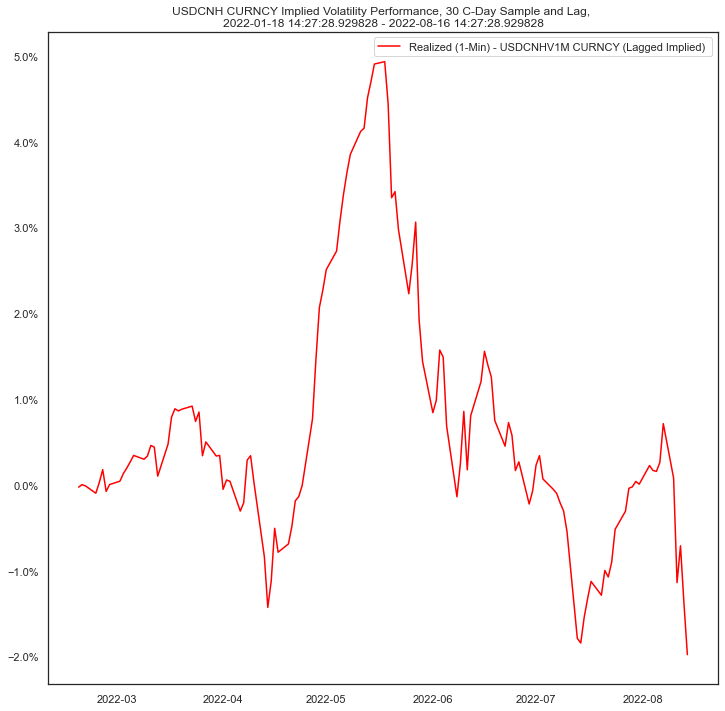

In [7]:
implied_realized_vol("USDCNH CURNCY", sample_days = 30, window_days = 180, volticker = "USDCNHV1M CURNCY")